In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры модели
N = 25  # Число трейдеров, количество акций
M = 100  # Число предикторов у трейдера
J = 12  # Число рыночных характеристик
overline_d = 10  # Средний начальный дивиденд
phi = 0.95  # Коэффициент авторегрессии для дивидендов
sigma2_epsilon = 0.0743  # Стандартное отклонение ошибки для дивидендов
r_f = 0.1  # Безрисковая ставка за период
lambda_param = 0.5  # Коэффициент функции полезности CARA
theta = 1/150  # Коэффициент экспоненциального сглаживания точности в режиме рациональных ожиданий
T = 200  # Количество временных периодов


In [102]:
def f():
    return phi / (1+r_f-phi)

def g():
    return (1+f())/r_f*((1-phi)*overline_d-lambda_param*(1+f())*sigma2_epsilon)
a_REE = phi
b_REE = (1-phi)*(1+f())*overline_d+g()
delta_a = 0.2
delta_b = 2
a_min = a_REE-delta_a
a_max = a_REE+delta_a
b_min = b_REE-delta_b
b_max = b_REE+delta_b

In [103]:
print(f"a_min = {a_min}, a_max = {a_max} \n b_min = {b_min}, b_max = {b_max}")

a_min = 0.75, a_max = 1.15 
 b_min = 18.354888888888922, b_max = 22.354888888888922


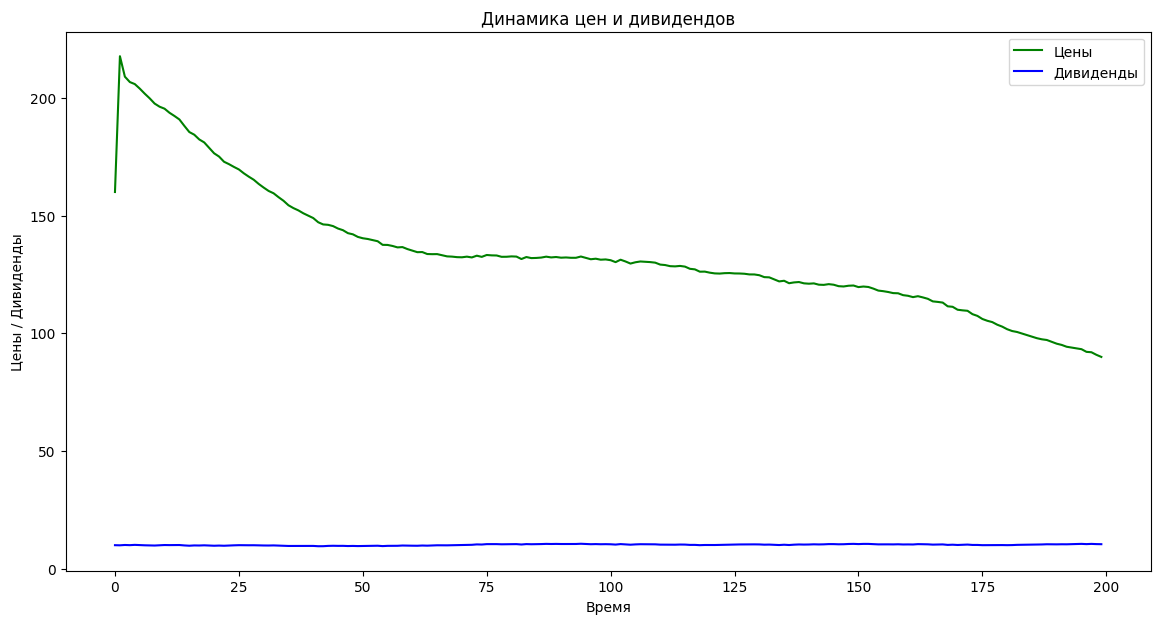

In [104]:
# Инициализация предикторов
predictors = []
for i in range(N):
    trader_predictors = []
    # Гарантируем наличие варианта со всеми #
    trader_predictors.append({'condition': ['#'] * J, 'a': np.random.uniform(a_min, a_max), 'b': np.random.uniform(b_min, b_max), 'sigma2': np.random.rand()})  
    
    
    # Генерация остальных вариантов
    while len(trader_predictors) < M:
        condition = np.random.choice(['0', '1', '#'], size=J)
        a = np.random.uniform(a_min, a_max)
        b = np.random.uniform(b_min, b_max)
        sigma2 = np.random.rand()
        new_predictor = {'condition': condition, 'a': a, 'b': b, 'sigma2': sigma2}
        
        # Проверка на дубликат
        is_duplicate = False
        for existing_predictor in trader_predictors:
            if np.array_equal(new_predictor['condition'], existing_predictor['condition']):
                is_duplicate = True
                break
        
        # Добавление нового варианта, если он не дубликат
        if not is_duplicate:
            trader_predictors.append(new_predictor)
    predictors.append(trader_predictors)

prices = []
dividends = []
# Инициализация
begin_price = overline_d * 16
d_prev = overline_d
p_prev = begin_price
dividends.append(d_prev)
prices.append(p_prev)

def evaluate_condition(condition, bits):
    return all(c == '#' or b == c for c, b in zip(condition, bits))
def calculate_moving_averages(prices, window_sizes):
  """
  Рассчитывает скользящее среднее для массива цен с заданными размерами окна.

  Args:
    prices: Массив цен.
    window_sizes: Список размеров окна.

  Returns:
    Массив значений
  """

  moving_averages = []
  for window_size in window_sizes:
    # Если размер окна больше длины массива, используем всю длину массива
    actual_window_size = min(window_size, len(prices))
    # Расчет скользящего среднего с помощью функции convolve
    moving_average = np.convolve(prices, np.ones(actual_window_size), 'valid') / actual_window_size
    moving_averages.append(moving_average)
  return moving_averages

p_t = 0
for t in range(1, T):
    # Дивиденд
    epsilon_t = np.random.normal(0, sigma2_epsilon)
    d_t = overline_d + phi * (d_prev - overline_d) + epsilon_t
    
    dividends.append(d_t)

    # Строим строку битов, описывающую рынок
    descriptor_one = p_prev * r_f / d_t
    window_sizes = [5, 10, 100, 500]
    descriptor_two = calculate_moving_averages(prices, window_sizes)
    market_bits = [int(descriptor_one>0.25), int(descriptor_one>0.5),\
                   int(descriptor_one>0.75), int(descriptor_one>0.875),\
                   int(descriptor_one>1.0), int(descriptor_one> 1.125),\
                   int(p_prev > np.mean(descriptor_two[0])), int(p_prev > np.mean(descriptor_two[1])),\
                   int(p_prev > np.mean(descriptor_two[2])), int(p_prev > np.mean(descriptor_two[3])),
                   1, 0]

    # Рассчитываем спрос и предложение
    sum_alpha = sum_beta = 0
    
    u_w = - np.exp(-lambda_param)

    for i in range(N):
        active_predictors = [p for p in predictors[i] if evaluate_condition(p['condition'], market_bits)]
        if active_predictors:
            best_predictor = min(active_predictors, key=lambda x: x['sigma2'])
            a, b = best_predictor['a'], best_predictor['b']
            sigma2 = best_predictor['sigma2']
            alpha = (a * d_t + b) / (lambda_param * sigma2)
            beta = (a - (1 + r_f)) / (lambda_param * sigma2)
        else:
            alpha = beta = 0
        
        sum_alpha += alpha
        sum_beta += beta
        
    # Равновесная цена
    if sum_beta != 0:
        expected_p_t = (N - sum_alpha) / sum_beta
        p_t = expected_p_t
        if(expected_p_t < 0): # ограничение снизу
            p_t = p_prev
        if(expected_p_t > begin_price * 2): # ограничение сверху
            p_t = p_prev
    else:
        p_t = p_prev
    
    prices.append(p_t)
    p_prev = p_t
    d_prev = d_t

    # Пересчитываем дисперсии для активных предикторов
    for i in range(N):
        for p in predictors[i]:
            if evaluate_condition(p['condition'], market_bits):
                p['sigma2'] = (1 - theta) * p['sigma2'] + theta * ((p_t + d_t) - (p['a'] * p_t + p['b']))**2

# Визуализация результатов
plt.figure(figsize=(14,7))
plt.plot(prices, 'g', label="Цены")
plt.plot(dividends, 'b', label="Дивиденды")
plt.title('Динамика цен и дивидендов')
plt.xlabel('Время')
plt.ylabel('Цены / Дивиденды')
plt.legend()
plt.show()

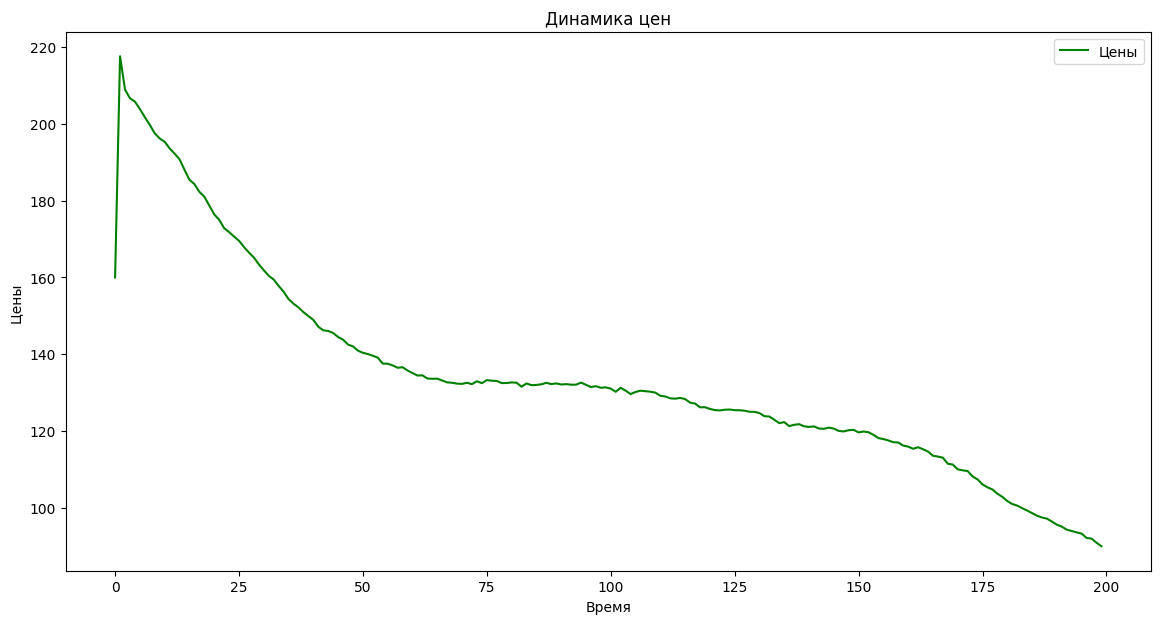

In [105]:
plt.figure(figsize=(14,7))
plt.plot(prices, 'g', label="Цены")
plt.title('Динамика цен')
plt.xlabel('Время')
plt.ylabel('Цены ')
plt.legend()

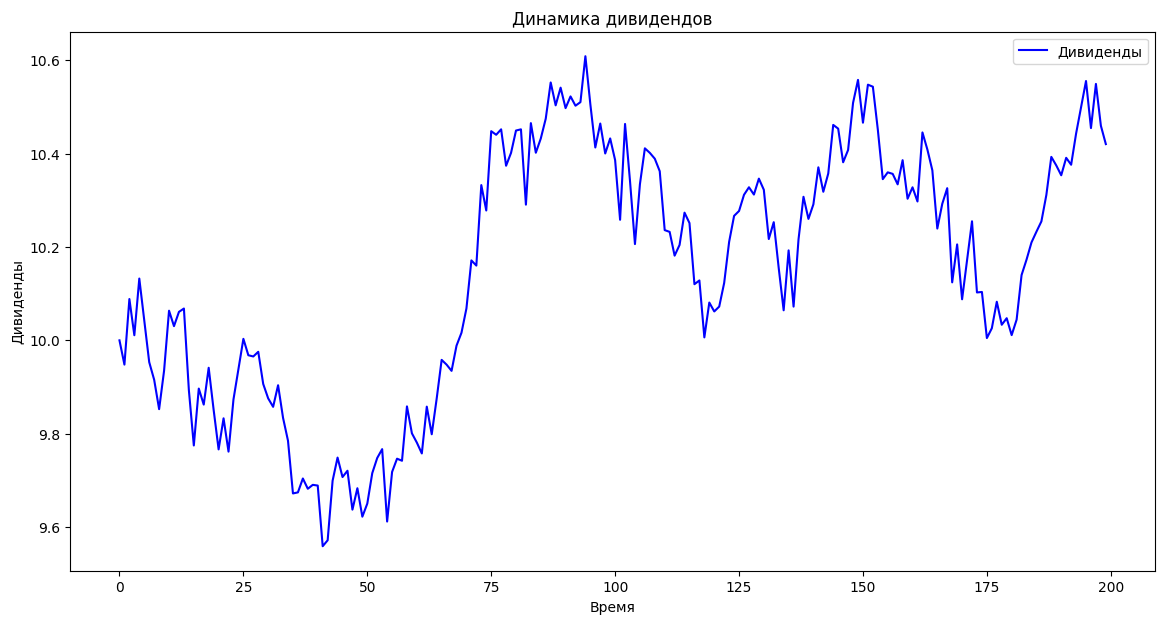

In [106]:

plt.figure(figsize=(14,7))
plt.plot(dividends, 'b', label="Дивиденды")
plt.title('Динамика дивидендов')
plt.xlabel('Время')
plt.ylabel('Дивиденды')
plt.legend()